In [1]:
! python --version

Python 3.11.9


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


import squidpy as sq
import scanpy as sc

import scipy.sparse

import anndata as an

from pathlib import Path

from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np
from Bio.Seq import Seq

from Bio import AlignIO

import subprocess


from itertools import combinations

## first, I will show the alignment of the homoeologs, and the binding of probes against each

I downloaded MUSCLE for alignment: https://github.com/rcedgar/muscle/releases

In [4]:
# ---- Input individual files ----
files = [
    "sequence_files/Triticum_aestivum_upstreamincluded_TraesCS1B02G448400_sequence.fa",
    "sequence_files/Triticum_aestivum__upstreamincluded_TraesCS1A02G418400_sequence.fa",
    "sequence_files/Triticum_aestivum_TraesCS1D02G426100_sequence.fa"
]

# ---- Combine into one file for alignment ----
combined_file = "unaligned_sequences.fasta"
records = []

for file in files:
    for record in SeqIO.parse(file, "fasta"):
        records.append(record)

# Write combined unaligned file
SeqIO.write(records, combined_file, "fasta")
print(f"✅ Combined {len(records)} sequences into {combined_file}")


✅ Combined 3 sequences into unaligned_sequences.fasta


In [5]:
# ---- Paths ----
muscle_exe = r"C:\Users\longk\MUSCLE\muscle-win64.v5.3.exe" 
aligned_file = "sequence_files/TraesCS1B02G448400_TraesCS1A02G418400_TraesCS1A02G418400_musclealigned.fasta"

# ---- Run MUSCLE ----
def run_muscle(input_fasta, output_fasta, muscle_exe):
    cmd = [muscle_exe, "-align", input_fasta, "-output", output_fasta]
    subprocess.run(cmd, check=True)
    print(f"✅ Alignment completed and saved to {output_fasta}")

run_muscle(combined_file, aligned_file, muscle_exe)


✅ Alignment completed and saved to TraesCS1B02G448400_TraesCS1A02G418400_TraesCS1A02G418400_musclealigned.fasta


In [6]:
# ---- Read alignment ----
alignment = AlignIO.read(aligned_file, "fasta")

# ---- Print in aligned format ----
print("\n🔍 Alignment:")
for record in alignment:
    print(f"{record.id:<25} {record.seq}")



🔍 Alignment:
TraesCS1A02G418400.1      CCCAGATCCGCCCCAAGGTCAAGAACCCACCTTTTTCCTCCTCATCCATGGGCGAGCAATCCCTCTCCCAGCCCTTTCCCCATCCCCATCCCCACCCCCTCTCCCCGTCGCCCCCCGCATCCGCCGCCGCTACGCCGCCAGCCACCGCCCTCGCCGTCTCCGCCTCCGCTTCCCGCCCCAAGAAGAAGCCCCGGTCGTCCGGCTCCAACCCGGCGCCCAAGAAGCCCCGCCTGGTGCCGTCCGTCCGGGGCCGGCCCCTGTCGGCGGACGGCGAGGTGGACGCGGCCATCCGCCACCTGCGCGCGGCCGACCCGGCCCTGGCCCCCGTCATCGACGCGCACGACCCCCCGTCGTTCCACTGCCCGCATCCCCCCTTCCACTCCCTCGTTCGATCCGTCCTCTACCAGCAGCTCGCCTTCAAGGCGGCCGCCTCCGTCTACTCCCGGTTCATCGCGCTCGTCGGCGGCGAGGCCGGCGTGCTCCCGGACGCTGTCCTCGCGCTCTCCGCCGAGCAGCTTCGCCAAATCGGGGTCTCCGCGCGCAAGGCCTCCTACCTCCATGACCTCGCCCGCAAGTATGCGTCGGGGATCCTCTCCGACGACAACATCGTTGCCATGGACGACCGCTCCCTCGCCGCCATGCTCACCATGGTCAACGGCATCGGCGCCTGGAGTGTTCACATGTTCATGATCTTCTCCCTAGCGCGCCCGGATGTGCTCCCCTCCGCGGATCTCGGGATCCGCAAGGGCGTGCAGATGCTGTATGGGCTGGAGGATGTGCCCCGGCCGTCGCAGATGGAGAAGCTCTGCGAGCGCTGGCGCCCTTACCGCTCCGTCGCCGCGTGGTACATGTGGCGCCTCATCGAGTCCAAGGCGGCGCAGACGGCAGGGGCCATGCCTGTAGTGCCACCTGCAATGCCTGCGCCCAGTGAGGAGTTCATGCTCCAGCAGCACCAGCAGC

In [9]:
# ---- Load Aligned Sequences ----
def read_fasta(file):
    """Reads aligned FASTA and returns dictionary {ID: sequence}"""
    return {record.id: str(record.seq) for record in SeqIO.parse(file, "fasta")}

aligned_sequences = read_fasta("sequence_files/TraesCS1B02G448400_TraesCS1A02G418400_TraesCS1A02G418400_musclealigned.fasta")  # replace with your file
seq_ids = list(aligned_sequences.keys())

# ---- Compute Pairwise Percent Identity ----
def compute_percent_identity(seq1, seq2):
    """Computes percent identity between two aligned sequences"""
    matches = sum(a == b for a, b in zip(seq1, seq2))
    total = len(seq1)
    return (matches / total) * 100

# ---- Generate Pairwise Results ----
results = []
for id1, id2 in combinations(seq_ids, 2):
    seq1 = aligned_sequences[id1]
    seq2 = aligned_sequences[id2]
    identity = compute_percent_identity(seq1, seq2)
    results.append((id1, id2, identity))

# ---- Print Results ----
for id1, id2, identity in results:
    print(f"{id1} vs {id2}: {identity:.2f}% identity")


TraesCS1A02G418400.1 vs TraesCS1B02G448400.1: 94.79% identity
TraesCS1A02G418400.1 vs TraesCS1D02G426100.1: 96.11% identity
TraesCS1B02G448400.1 vs TraesCS1D02G426100.1: 96.68% identity


## reading in the probe sequences designed against TraesCS1B02G448400

In [10]:
# ---- 1. Load Homoeolog Sequences (FASTA) ----
def read_fasta(file):
    sequences = {record.id: str(record.seq) for record in SeqIO.parse(file, "fasta")}
    return sequences

# ---- 2. Load Probe Sequences ----
probes_file = "TraesCS1B02G448400_probes.fasta"  # Your local probe file
probes = read_fasta(probes_file)
probes

{'TraesCS1B02G448400_1_6484': 'AAAGGGCTGGGAGAGGGATTGCTCGCCCAT',
 'TraesCS1B02G448400_1_6485': 'GGGGATGGGGAAAGGGCTGGGAGAGGGATT',
 'TraesCS1B02G448400_1_6486': 'GACGGGGAGAGGGGATGGGGAAAGGGCTGG',
 'TraesCS1B02G448400_1_6487': 'CTTCTTCTTGGGGCGGGAAGCGGAGGGGGG',
 'TraesCS1B02G448400_1_6488': 'TGGAGCCGGACGACCGGGCCTTCTTCTTGG',
 'TraesCS1B02G448400_1_6489': 'GAACGACGGGGGGTCGTGCGCGTCGATGAC',
 'TraesCS1B02G448400_1_6490': 'AATGGGGGATGCGGGCAGTGGAACGACGGG',
 'TraesCS1B02G448400_1_6491': 'GAGGGAGTGAAATGGGGGATGCGGGCAGTG',
 'TraesCS1B02G448400_1_6492': 'CGGATCGGACGAGGGAGTGAAATGGGGGAT',
 'TraesCS1B02G448400_1_6493': 'TGGTAGAGAACGGATCGGACGAGGGAGTGA',
 'TraesCS1B02G448400_1_6494': 'GATGAACCGGGAGTAGACGGAGGCGGCGGC',
 'TraesCS1B02G448400_1_6495': 'CGACGAGCGCGATGAACCGGGAGTAGACGG',
 'TraesCS1B02G448400_1_6496': 'CGATTTGGCGGAGCTGCTCGGGGGAGAGCG',
 'TraesCS1B02G448400_1_6497': 'GCGGAGACCCCGATTTGGCGGAGCTGCTCG',
 'TraesCS1B02G448400_1_6498': 'ATGGAGGTAGGACGCCTTGCGCGCGGAGAC',
 'TraesCS1B02G448400_1_6499': 'GGGCGAGGT

### create the reverse complement of probes 

In [11]:
def reverse_complement_probes(probes):
    """Takes a dictionary of probe sequences and returns their reverse complements."""
    return {probe_id: str(Seq(seq).reverse_complement()) for probe_id, seq in probes.items()}

# Apply to your probes
probes_rc = reverse_complement_probes(probes)

# Print results
for probe_id, seq in probes_rc.items():
    print(f"{probe_id}: {seq}")


TraesCS1B02G448400_1_6484: ATGGGCGAGCAATCCCTCTCCCAGCCCTTT
TraesCS1B02G448400_1_6485: AATCCCTCTCCCAGCCCTTTCCCCATCCCC
TraesCS1B02G448400_1_6486: CCAGCCCTTTCCCCATCCCCTCTCCCCGTC
TraesCS1B02G448400_1_6487: CCCCCCTCCGCTTCCCGCCCCAAGAAGAAG
TraesCS1B02G448400_1_6488: CCAAGAAGAAGGCCCGGTCGTCCGGCTCCA
TraesCS1B02G448400_1_6489: GTCATCGACGCGCACGACCCCCCGTCGTTC
TraesCS1B02G448400_1_6490: CCCGTCGTTCCACTGCCCGCATCCCCCATT
TraesCS1B02G448400_1_6491: CACTGCCCGCATCCCCCATTTCACTCCCTC
TraesCS1B02G448400_1_6492: ATCCCCCATTTCACTCCCTCGTCCGATCCG
TraesCS1B02G448400_1_6493: TCACTCCCTCGTCCGATCCGTTCTCTACCA
TraesCS1B02G448400_1_6494: GCCGCCGCCTCCGTCTACTCCCGGTTCATC
TraesCS1B02G448400_1_6495: CCGTCTACTCCCGGTTCATCGCGCTCGTCG
TraesCS1B02G448400_1_6496: CGCTCTCCCCCGAGCAGCTCCGCCAAATCG
TraesCS1B02G448400_1_6497: CGAGCAGCTCCGCCAAATCGGGGTCTCCGC
TraesCS1B02G448400_1_6498: GTCTCCGCGCGCAAGGCGTCCTACCTCCAT
TraesCS1B02G448400_1_6499: GCAAGGCGTCCTACCTCCATGACCTCGCCC
TraesCS1B02G448400_1_6500: CTCGCCCGCAAGTACGCGTCGGGGATCCTC
TraesCS1B02G44

In [12]:
from Bio import AlignIO

# ---- Parameters ----
aligned_file = "sequence_files/TraesCS1B02G448400_TraesCS1A02G418400_TraesCS1A02G418400_musclealigned.fasta"
ref_id = 'TraesCS1B02G448400.1'
other_ids = ['TraesCS1A02G418400.1', 'TraesCS1D02G426100.1']
wrap_width = 100  # or 150 or 300

# ---- Load Aligned Sequences ----
alignment = AlignIO.read(aligned_file, "fasta")
aligned_sequences = {record.id: str(record.seq) for record in alignment}

# ---- Generate Dot Notation Alignment ----
ref_seq = aligned_sequences[ref_id]
text_output = {ref_id: ref_seq}

for other_id in other_ids:
    seq = aligned_sequences[other_id]
    simplified = ''.join(['.' if b == r and b != '-' else b for b, r in zip(seq, ref_seq)])
    text_output[other_id] = simplified

# ---- Print Wrapped Alignment ----
print("\n\n🔍 Simplified Alignment View (Dots = Match to Reference):\n")
for i in range(0, len(ref_seq), wrap_width):
    for seq_id in [ref_id] + other_ids:
        print(f"{seq_id:<25} {text_output[seq_id][i:i+wrap_width]}")
    print()




🔍 Simplified Alignment View (Dots = Match to Reference):

TraesCS1B02G448400.1      CCCAGATCCACCCCAAGGTCAAGAACCCACCTTTTTCCTCCTCATCCATGGGCGAGCAATCCCTCTCCCAGCCCTTTCCCCATC------------CCCT
TraesCS1A02G418400.1      .........G..........................................................................CCCATCCCCACC....
TraesCS1D02G426100.1      ...........-..................G.....................................................------------....

TraesCS1B02G448400.1      CTCCCCGTCGCCCGCCGCATCCGCCGCCGCTACGCCGCCAGCCACCGCCCTCGTCGTCCCCCCCTCCGCTTCCCGCCCCAAGAAGAAGGCCCGGTCGTCC
TraesCS1A02G418400.1      .............C.......................................C....T..G..........................C...........
TraesCS1D02G426100.1      .............C................G......................C....T..G..........................C...........

TraesCS1B02G448400.1      GGCTCCAACCCGGCGCCCAAGAAGCCCCGCCTGGTGCCGTCCGTCCGGGGCCGGCCCCTCTCGGCCGACGGCGAGGTGGACGCGGCCATCCGCCACCTGC
TraesCS1A02G418400.1      .......................

## save an image of where the probes bind across the transcript 

✅ Alignment with probes saved as SVG and PNG.


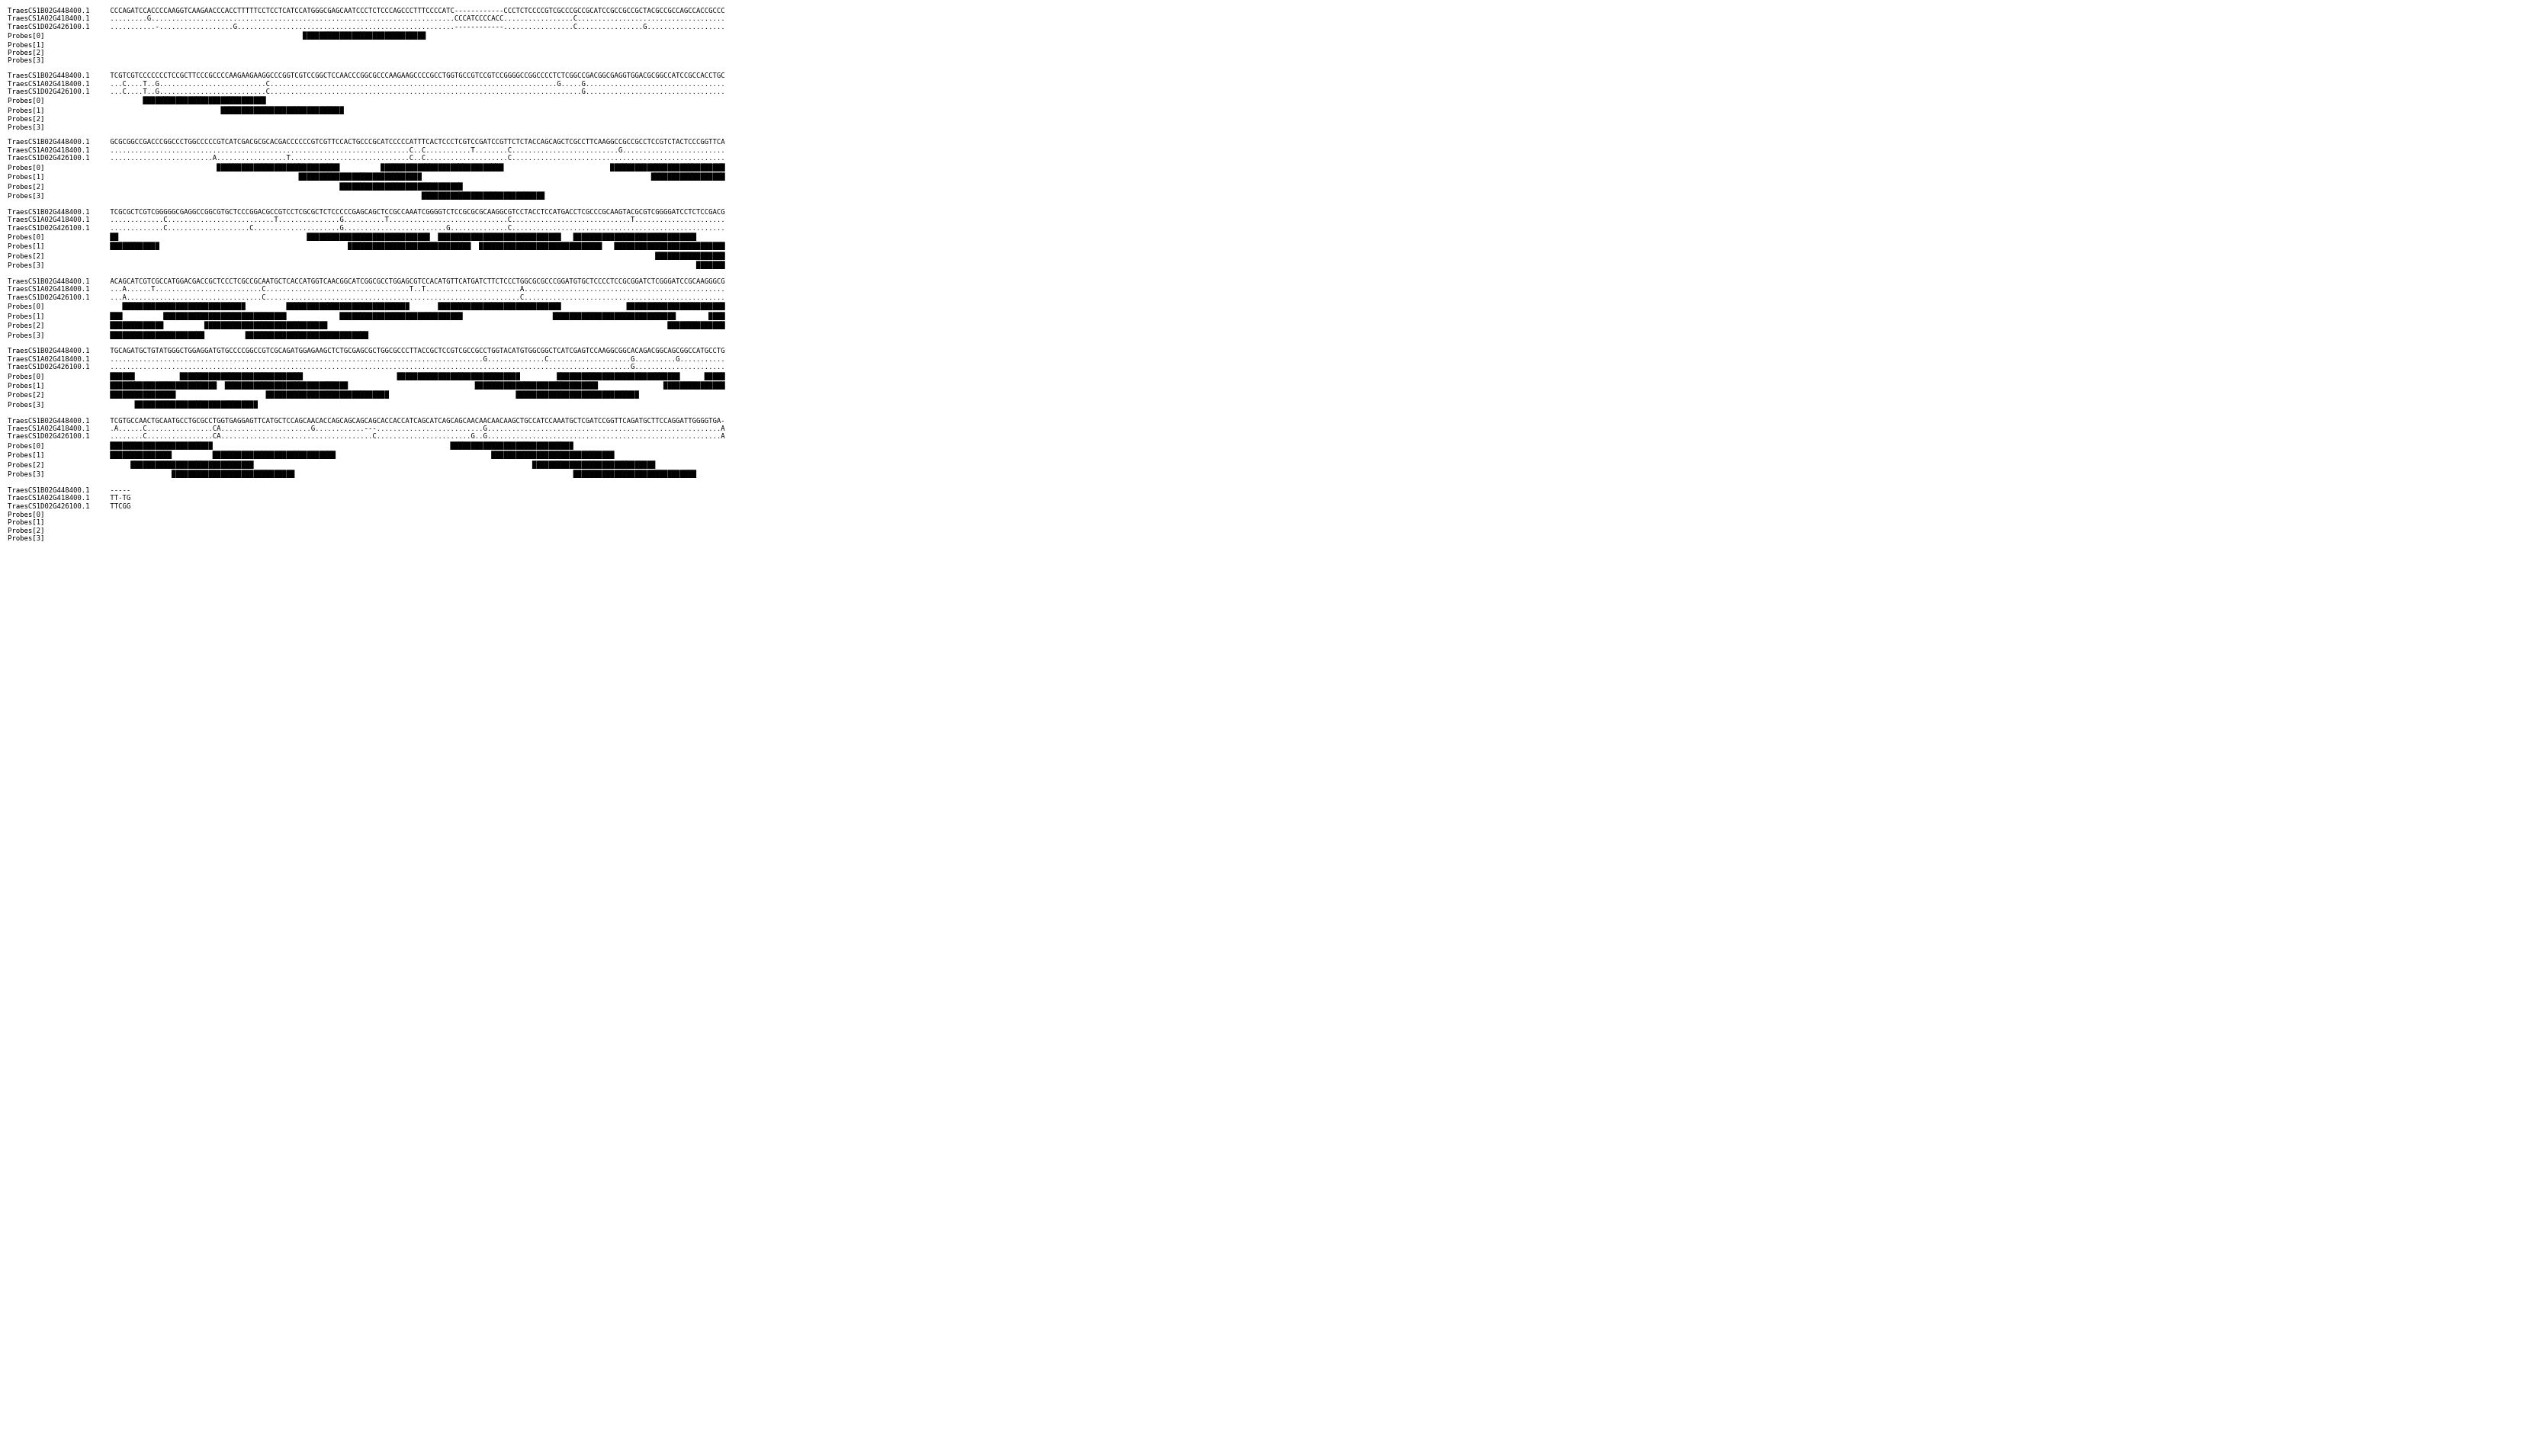

In [13]:
# ---- Parameters ----
aligned_file = "sequence_files/TraesCS1B02G448400_TraesCS1A02G418400_TraesCS1A02G418400_musclealigned.fasta"
probes_file = "probe_files/TraesCS1B02G448400_probes.fasta"
ref_id = 'TraesCS1B02G448400.1'
other_ids = ['TraesCS1A02G418400.1', 'TraesCS1D02G426100.1']
wrap_width = 150  # <- nucleotides per line

# ---- Load Sequences ----
def read_fasta(file):
    return {record.id.split()[0]: str(record.seq) for record in SeqIO.parse(file, "fasta")}

aligned_sequences = read_fasta(aligned_file)
probes = read_fasta(probes_file)
probes_rc = {pid: str(Seq(seq).reverse_complement()) for pid, seq in probes.items()}

# ---- Dot Notation ----
ref_seq = aligned_sequences[ref_id]
text_output = {ref_id: ref_seq}
for other_id in other_ids:
    seq = aligned_sequences[other_id]
    simplified = ''.join(['.' if b == r and b != '-' else b for b, r in zip(seq, ref_seq)])
    text_output[other_id] = simplified

# ---- Identify Probe Binding Positions (Only in ref) ----
unique_probe_binding_positions = set()
filtered_probe_bindings = {}
for probe_id, probe_seq in probes_rc.items():
    start = 0
    while (start := ref_seq.find(probe_seq, start)) != -1:
        probe_range = (start, start + len(probe_seq))
        if probe_range not in unique_probe_binding_positions:
            unique_probe_binding_positions.add(probe_range)
            filtered_probe_bindings.setdefault(probe_id, []).append(probe_range)
        start += 1

# ---- Build Stacked Probe Rows ----
probe_length = len(ref_seq)
probe_layers = []
all_positions = sorted([pos for plist in filtered_probe_bindings.values() for pos in plist], key=lambda x: x[0])
for start, end in all_positions:
    placed = False
    for layer in probe_layers:
        has_conflict = any(layer[i] != ' ' for i in range(start - 1, end + 1) if 0 <= i < len(layer))
        if not has_conflict:
            for i in range(start, end):
                layer[i] = '█'
            placed = True
            break
    if not placed:
        new_layer = [' '] * probe_length
        for i in range(start, end):
            new_layer[i] = '█'
        probe_layers.append(new_layer)

probe_layer_strings = [''.join(layer) for layer in probe_layers]

# ---- Build Wrapped Alignment with Probes ----
output_lines = []
label_width = 25
for i in range(0, len(ref_seq), wrap_width):
    for seq_id in [ref_id] + other_ids:
        output_lines.append(f"{seq_id:<{label_width}}{text_output[seq_id][i:i+wrap_width]}")
    for idx, layer_str in enumerate(probe_layer_strings):
        output_lines.append(f"Probes[{idx}]".ljust(label_width) + layer_str[i:i+wrap_width])
    output_lines.append("")

output_text = "\n".join(output_lines)

# ---- Plot Figure ----
fig_width = wrap_width / 4.5  # Wider figure to fit 150 nt per row
fig_height = len(output_lines) * 0.3
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

ax.text(0, 1, output_text, fontsize=6.5, family='monospace', va='top')
ax.axis("off")
plt.tight_layout()

# ---- Save Image ----
plt.savefig("figures/alignment_150nt_per_line.svg", format="svg", dpi=700)
plt.savefig("sigures/alignment_150nt_per_line.png", format="png", dpi=700)
print("✅ Alignment with probes saved as SVG and PNG.")


## Next, show the rates of non-homoeolog binding compared to blank probes

In [6]:
# Read the list of genes, 200 spike genes subset 
genes_to_include_file =  "GenePanel/filerecords/subset_spikegenes_list.txt"

with open(genes_to_include_file, "r") as file:
    genes_to_include = [line.strip() for line in file]

In [7]:
import warnings
warnings.simplefilter("ignore")


#VGN1a6
adata_VGN1a6 = sq.read.vizgen(
    path="cell_segmentation/VGN1a_region6_output/",
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv"
)
# filters to 200 genes 
adata_VGN1a6 = adata_VGN1a6[:, adata_VGN1a6.var_names.isin(genes_to_include)]

#VGN1a4
adata_VGN1a4 = sq.read.vizgen(
    path="cell_segmentation/VGN1a_region4_output/",
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv"
)
# filters to 200 genes
adata_VGN1a4 = adata_VGN1a4[:, adata_VGN1a4.var_names.isin(genes_to_include)]

#VGN1b6
adata_VGN1b6 = sq.read.vizgen(
    path="cell_segmentation/VGN1b_region6_output/",
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv"
)

#set the local min & max of dataframe
region_min_x = 5001.371569839002
region_min_y = 3989.694988634645
region_max_x = 5829.68
region_max_y = 6225.69510252610

# Filter observations based on the defined region
region_mask = (
    (adata_VGN1b6.obs['min_x'] >= region_min_x) &
    (adata_VGN1b6.obs['min_y'] >= region_min_y) &
    (adata_VGN1b6.obs['max_x'] <= region_max_x) &
    (adata_VGN1b6.obs['max_y'] <= region_max_y)
)
adata_VGN1b6 = adata_VGN1b6[region_mask]
# filters to 200 genes
adata_VGN1b6 = adata_VGN1b6[:, adata_VGN1b6.var_names.isin(genes_to_include)]

#VGN1b8
adata_VGN1b8 = sq.read.vizgen(
    path="cell_segmentation/VGN1b_region8_output/",
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv"
)

# Define the coordinates of the region you are interested in
region_min_x = 873.0
region_min_y = 6207.0
region_max_x = 1855.0
region_max_y = 7558.0

# Filter observations based on the defined region
region_mask = (
    (adata_VGN1b8.obs['min_x'] >= region_min_x) &
    (adata_VGN1b8.obs['min_y'] >= region_min_y) &
    (adata_VGN1b8.obs['max_x'] <= region_max_x) &
    (adata_VGN1b8.obs['max_y'] <= region_max_y)
)
adata_VGN1b8 = adata_VGN1b8[region_mask]
# filters to 200 genes
adata_VGN1b8 = adata_VGN1b8[:, adata_VGN1b8.var_names.isin(genes_to_include)]

#VGN1c2
adata_VGN1c2 = sq.read.vizgen(
    path="cell_segmentation/VGN1c_region2_output/",
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv"
)

# filters to 200 genes
adata_VGN1c2 = adata_VGN1c2[:, adata_VGN1c2.var_names.isin(genes_to_include)]

#VGN1c3
adata_VGN1c3 = sq.read.vizgen(
    path="cell_segmentation/VGN1c_region3_output/",
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv"
)

# filters to 200 genes
adata_VGN1c3 = adata_VGN1c3[:, adata_VGN1c3.var_names.isin(genes_to_include)]

#VGN1e1
adata_VGN1e1 = sq.read.vizgen(
    path="cell_segmentation/VGN1e_region1_output/",
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv"
)
# Define the coordinates of the region you are interested in
region_min_x = 3284.0
region_min_y = 6279.0
region_max_x = 4481.0
region_max_y = 7870.0

# Filter observations based on the defined region
region_mask = (
    (adata_VGN1e1.obs['min_x'] >= region_min_x) &
    (adata_VGN1e1.obs['min_y'] >= region_min_y) &
    (adata_VGN1e1.obs['max_x'] <= region_max_x) &
    (adata_VGN1e1.obs['max_y'] <= region_max_y)
)
adata_VGN1e1 = adata_VGN1e1[region_mask]
# filters to 200 genes
adata_VGN1e1 = adata_VGN1e1[:, adata_VGN1e1.var_names.isin(genes_to_include)]

#VGN1e9
adata_VGN1e9 = sq.read.vizgen(
    path="cell_segmentation/VGN1e_region9_output/",
    counts_file="cell_by_gene.csv",
    meta_file="cell_metadata.csv",
    transformation_file="micron_to_mosaic_pixel_transform.csv"
)

region_min_x = 6403.0
region_min_y = 7843.0
region_max_x = 7400.0
region_max_y = 9614.0

# Filter observations based on the defined region
region_mask = (
    (adata_VGN1e9.obs['min_x'] >= region_min_x) &
    (adata_VGN1e9.obs['min_y'] >= region_min_y) &
    (adata_VGN1e9.obs['max_x'] <= region_max_x) &
    (adata_VGN1e9.obs['max_y'] <= region_max_y)
)
adata_VGN1e9 = adata_VGN1e9[region_mask]
# filter to 200 genes
adata_VGN1e9 = adata_VGN1e9[:, adata_VGN1e9.var_names.isin(genes_to_include)]


adata_VGN1a6.var_names_make_unique()
adata_VGN1a4.var_names_make_unique()
adata_VGN1b6.var_names_make_unique()
adata_VGN1b8.var_names_make_unique()
adata_VGN1c2.var_names_make_unique()
adata_VGN1c3.var_names_make_unique()
adata_VGN1e1.var_names_make_unique()
adata_VGN1e9.var_names_make_unique()
#calculate the QC for each sample, look at the top variable genes
sc.pp.calculate_qc_metrics(adata_VGN1a6, percent_top=(50, 100, 150), inplace=True)
sc.pp.calculate_qc_metrics(adata_VGN1a4, percent_top=(50, 100, 150), inplace=True)
sc.pp.calculate_qc_metrics(adata_VGN1b6, percent_top=(50, 100, 150),inplace=True)
sc.pp.calculate_qc_metrics(adata_VGN1b8, percent_top=(50, 100, 150),inplace=True)
sc.pp.calculate_qc_metrics(adata_VGN1c2, percent_top=(50, 100, 150),inplace=True)
sc.pp.calculate_qc_metrics(adata_VGN1c3, percent_top=(50, 100, 150),inplace=True)
sc.pp.calculate_qc_metrics(adata_VGN1e1, percent_top=(50, 100, 150),inplace=True)
sc.pp.calculate_qc_metrics(adata_VGN1e9, percent_top=(50, 100, 150),inplace=True)


#for each sample, filter cells so if there are less than 25 counts in the cell, it gets filtered out from dataset
sc.pp.filter_cells(adata_VGN1a6, min_counts=25)
sc.pp.filter_cells(adata_VGN1a4, min_counts=25)
sc.pp.filter_cells(adata_VGN1b6, min_counts=25)
sc.pp.filter_cells(adata_VGN1b8, min_counts=25)
sc.pp.filter_cells(adata_VGN1c2, min_counts=25)
sc.pp.filter_cells(adata_VGN1c3, min_counts=25)
sc.pp.filter_cells(adata_VGN1e1, min_counts=25)
sc.pp.filter_cells(adata_VGN1e9, min_counts=25)

#Filter cells out by cell volume
# Filter adata_VGN1a6
adata_VGN1a6 = adata_VGN1a6[adata_VGN1a6.obs['volume'] > 500]
adata_VGN1a6 = adata_VGN1a6[adata_VGN1a6.obs['volume'] < 10000]
# Filter adata_VGN1a4
adata_VGN1a4 = adata_VGN1a4[adata_VGN1a4.obs['volume'] > 500]
adata_VGN1a4 = adata_VGN1a4[adata_VGN1a4.obs['volume'] < 10000]

# Filter adata_VGN1b6
adata_VGN1b6 = adata_VGN1b6[adata_VGN1b6.obs['volume'] > 500]
adata_VGN1b6 = adata_VGN1b6[adata_VGN1b6.obs['volume'] < 10000]
# Filter adata_VGN1b8
adata_VGN1b8 = adata_VGN1b8[adata_VGN1b8.obs['volume'] > 500]
adata_VGN1b8 = adata_VGN1b8[adata_VGN1b8.obs['volume'] < 10000]

# Filter adata_VGN1e1
adata_VGN1e1 = adata_VGN1e1[adata_VGN1e1.obs['volume'] > 500]
adata_VGN1e1 = adata_VGN1e1[adata_VGN1e1.obs['volume'] < 10000]
# Filter adata_VGN1e9
adata_VGN1e9 = adata_VGN1e9[adata_VGN1e9.obs['volume'] > 500]
adata_VGN1e9 = adata_VGN1e9[adata_VGN1e9.obs['volume'] < 10000]

# Filter adata_VGN1c2
adata_VGN1c2 = adata_VGN1c2[adata_VGN1c2.obs['volume'] > 500]
adata_VGN1c2 = adata_VGN1c2[adata_VGN1c2.obs['volume'] < 10000]
# Filter adata_VGN1c3
adata_VGN1c3 = adata_VGN1c3[adata_VGN1c3.obs['volume'] > 500]
adata_VGN1c3 = adata_VGN1c3[adata_VGN1c3.obs['volume'] < 10000]


## Testing ABD non-homoeologous activity
I want to look at the number of blank probes compared to genes I designed to test ABD off target activity 

First, I want to calculate average blank counts per cell
At the same time, I will calculate average counts per cell for two genes, TraesCS1B02G448400 and TraesCS2A02G314100
Then I will plot these to compare

In [10]:
# Define your adata objects and sample names
samples = {
    'VGN1c2': adata_VGN1c2,
    'VGN1c3': adata_VGN1c3,
    'VGN1a6': adata_VGN1a6,
    'VGN1a4': adata_VGN1a4,
    'VGN1b6': adata_VGN1b6,
    'VGN1b8': adata_VGN1b8,
    'VGN1e1': adata_VGN1e1,
    'VGN1e9': adata_VGN1e9
}

# List of genes and blanks to filter
genes_and_blanks = [
    'TraesCS1B02G448400', 'TraesCS2A02G314100', 'Blank-0', 'Blank-1', 'Blank-2', 'Blank-3',
    'Blank-4', 'Blank-5', 'Blank-6', 'Blank-7', 'Blank-8', 'Blank-9', 'Blank-10', 
    'Blank-11', 'Blank-12', 'Blank-13', 'Blank-14'
]

# Initialize an empty list to store DataFrames for each sample
all_filtered_dfs = []

# Iterate through each sample
for sample_name, adata in samples.items():
    
    # Extract expression data
    expression_df = pd.DataFrame(
        adata.X.toarray() if isinstance(adata.X, scipy.sparse.csr_matrix) else adata.X,
        index=adata.obs_names,
        columns=adata.var_names
    )

    # Extract blank genes data
    blank_genes_data = adata.obsm['blank_genes']

    # Join on index
    expression_blanks_df = expression_df.join(blank_genes_data, how='inner')

    # Calculate the average for each column
    average_values = expression_blanks_df.mean()

    # Create a new DataFrame for average values and filter for specified genes/blanks
    average_df = pd.DataFrame(average_values, columns=['Average'])
    filtered_average_df = average_df.loc[genes_and_blanks]

    # Add a column to indicate the sample name
    filtered_average_df['Sample'] = sample_name

    # Append to the list
    all_filtered_dfs.append(filtered_average_df)

# Concatenate all dataframes into one
concatenated_filtered_df = pd.concat(all_filtered_dfs)

# Reset index to make 'Gene/Blank' a column
concatenated_filtered_df.reset_index(inplace=True)
concatenated_filtered_df.rename(columns={'index': 'Gene/Blank'}, inplace=True)

# Pivot to make Sample the index, Gene/Blank values as columns, and Average as values
reshaped_df = concatenated_filtered_df.pivot(index='Sample', columns='Gene/Blank', values='Average')

# Calculate the average for columns starting with "Blank" for each row
reshaped_df['Average_BlankCount'] = reshaped_df.filter(regex='^Blank').mean(axis=1)
reshaped_df



Gene/Blank,Blank-0,Blank-1,Blank-10,Blank-11,Blank-12,Blank-13,Blank-14,Blank-2,Blank-3,Blank-4,Blank-5,Blank-6,Blank-7,Blank-8,Blank-9,TraesCS1B02G448400,TraesCS2A02G314100,Average_BlankCount
Sample,,,,,,,,,,,,,,,,,,
VGN1a4,0.075020,0.019577,0.014879,0.013469,0.003446,0.006265,0.107909,0.029131,0.020360,0.017854,0.030227,0.008144,0.006421,0.028974,0.020673,0.194049,0.204385,0.026823
VGN1a6,0.035708,0.011101,0.009066,0.010731,0.001295,0.003515,0.061795,0.012951,0.013876,0.006475,0.014431,0.007586,0.005920,0.024237,0.016281,0.127475,0.124514,0.015665
VGN1b6,0.033494,0.031077,0.008287,0.024171,0.002417,0.014848,0.111878,0.026243,0.005180,0.012776,0.010014,0.014157,0.022099,0.011740,0.007597,0.278315,0.114986,0.022399
VGN1b8,0.018035,0.020883,0.006645,0.016137,0.002848,0.004271,0.061224,0.009967,0.004746,0.009018,0.006170,0.015187,0.022307,0.007119,0.005221,0.253441,0.120076,0.013985
VGN1c2,0.047613,0.029239,0.034376,0.043003,0.005203,0.013303,0.066447,0.046823,0.009681,0.017451,0.013105,0.013434,0.017912,0.033981,0.011129,0.212973,0.115575,0.026847
VGN1c3,0.044274,0.028982,0.028247,0.031452,0.004207,0.008948,0.065843,0.040401,0.007412,0.013489,0.014624,0.013957,0.014825,0.032922,0.011285,0.182838,0.097095,0.024058
VGN1e1,0.040742,0.033499,0.022635,0.011770,0.005885,0.003622,0.054323,0.035310,0.004527,0.015844,0.012223,0.020371,0.034405,0.020371,0.007243,0.191489,0.066093,0.021518
VGN1e9,0.029955,0.050351,0.019120,0.011472,0.004461,0.001912,0.043977,0.021033,0.005099,0.011472,0.009560,0.010835,0.020395,0.020395,0.006373,0.137030,0.058636,0.017761


In [11]:
# Print mean of 'TraesCS1B02G448400'
mean_gene = reshaped_df['TraesCS1B02G448400'].mean()
print(f"Mean value of TraesCS1B02G448400: {mean_gene}")

# Print mean of 'Average_BlankCount'
mean_blank = reshaped_df['Average_BlankCount'].mean()
print(f"Mean value of Average_BlankCount: {mean_blank}")

Mean value of TraesCS1B02G448400: 0.197201207280159
Mean value of Average_BlankCount: 0.02113187313079834


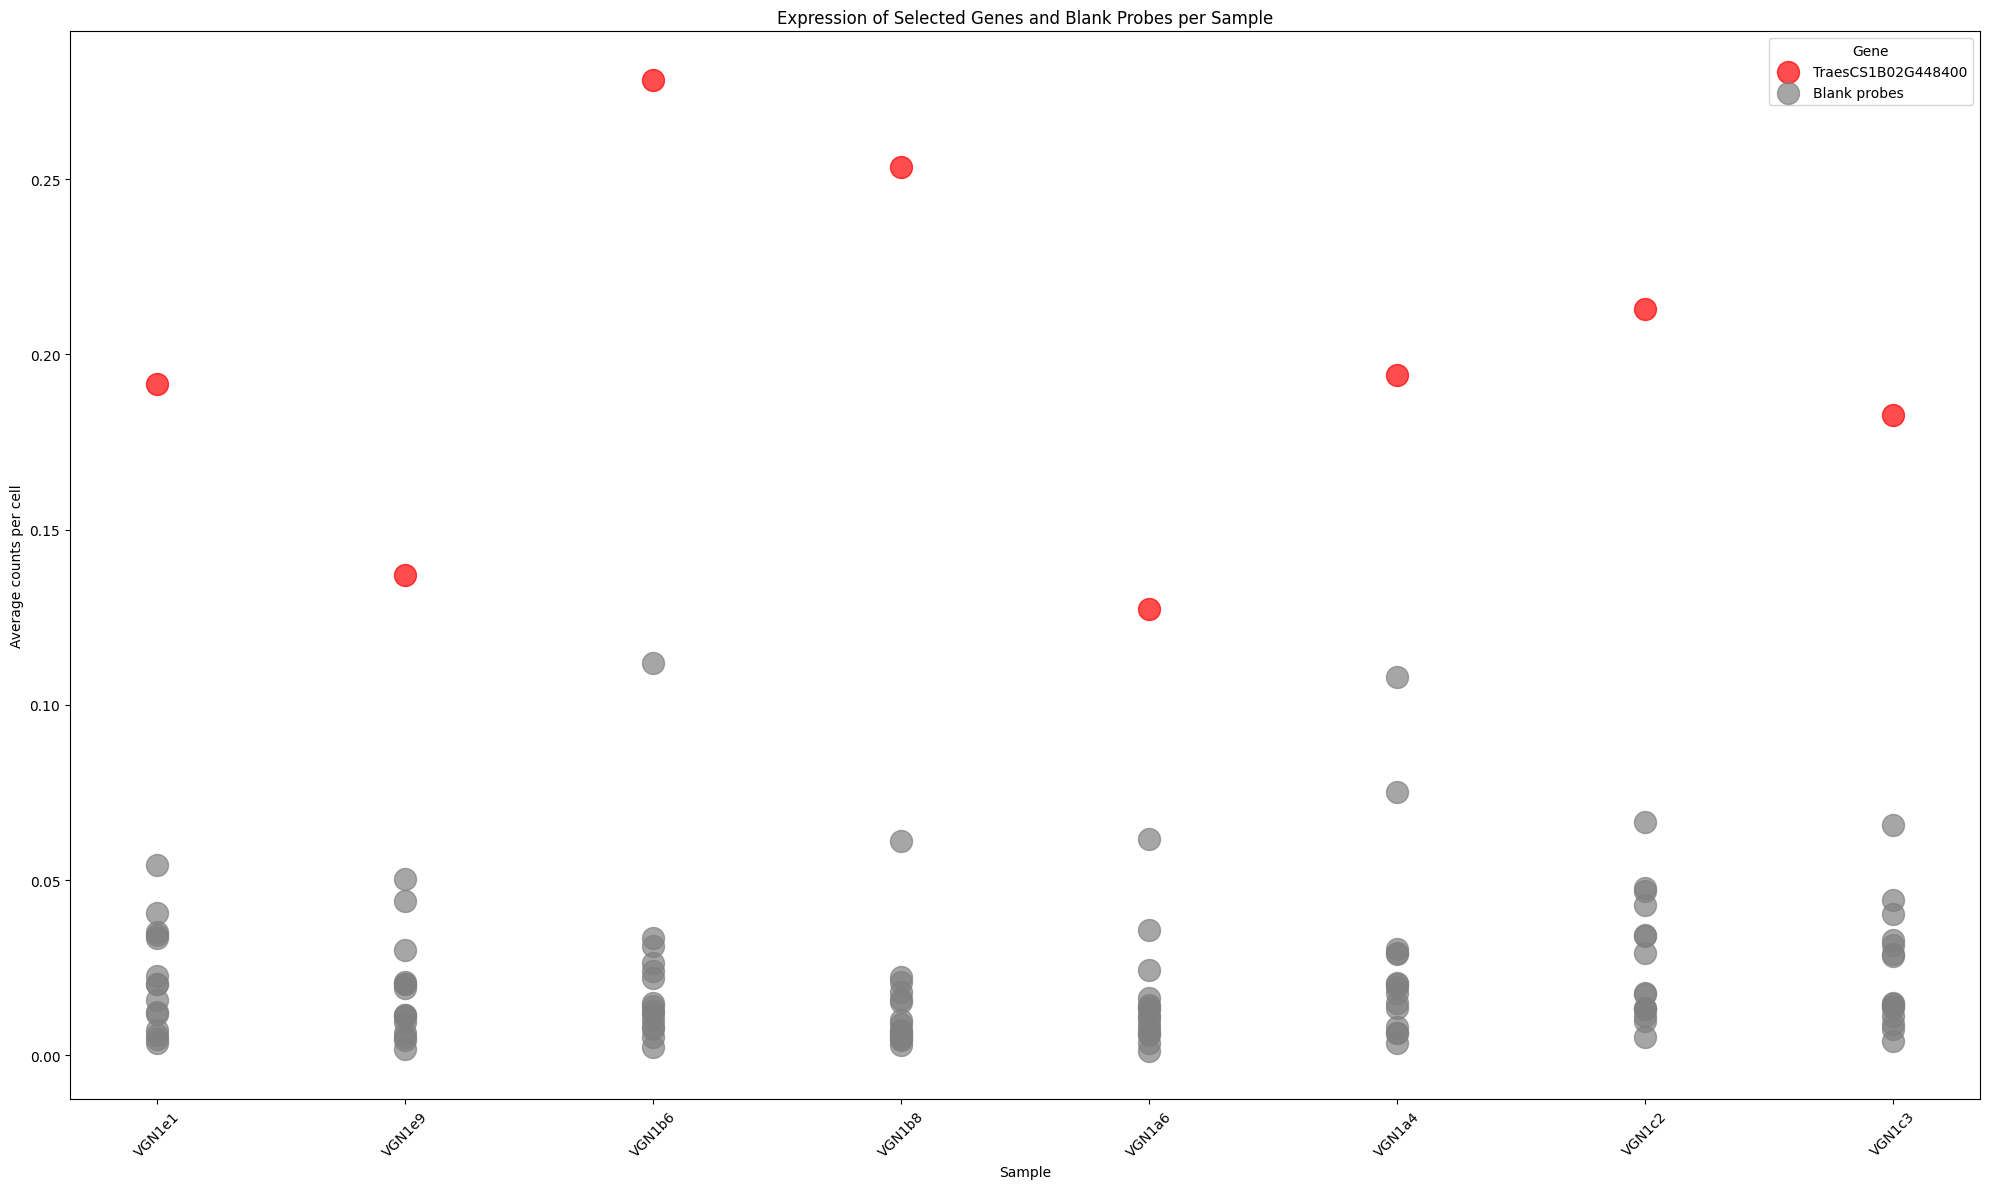

In [18]:
# Define columns to plot
columns_to_plot = [
    'TraesCS1B02G448400', 'Blank-0', 'Blank-1', 'Blank-2', 'Blank-3',
    'Blank-4', 'Blank-5', 'Blank-6', 'Blank-7', 'Blank-8', 'Blank-9', 'Blank-10', 
    'Blank-11', 'Blank-12', 'Blank-13', 'Blank-14'
]

# Specify the order of samples
sample_order = ['VGN1e1', 'VGN1e9', 'VGN1b6', 'VGN1b8', 'VGN1a6', 'VGN1a4', 'VGN1c2', 'VGN1c3']

# Reorder the DataFrame according to the specified sample order
plot_df = reshaped_df.loc[sample_order, columns_to_plot]

# Create the plot
plt.figure(figsize=(20, 12))

# Plot grey dots for Blank probes and add a legend entry for them
blank_plotted = False  # To ensure we only add one legend entry for 'Blank probes'
for col in columns_to_plot:
    if col.startswith("Blank"):
        color = 'grey'
        plt.scatter(plot_df.index, plot_df[col], color=color, s=250, alpha=0.7)
        if not blank_plotted:
            plt.scatter([], [], color='grey', label='Blank probes', s=250, alpha=0.7)  # Add grey dot to legend once
            blank_plotted = True
    elif col == 'TraesCS1B02G448400':
        plt.scatter(plot_df.index, plot_df[col], color='red', label='TraesCS1B02G448400', s=250, alpha=0.7)

# Add legend with the specified labels
plt.legend(title='Gene', loc='upper right')

# Set labels and title
plt.xlabel('Sample')
plt.ylabel('Average counts per cell')
plt.title('Expression of Selected Genes and Blank Probes per Sample')

# Adjust x-axis tick labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('qc/homoeolog_offtarget_activity/figures/ABD_blankprobes_avgexp_percell_TraesCS1B02G448400.svg',  dpi=700, bbox_inches='tight', format='svg', transparent=True)
# Show the plot
plt.show()


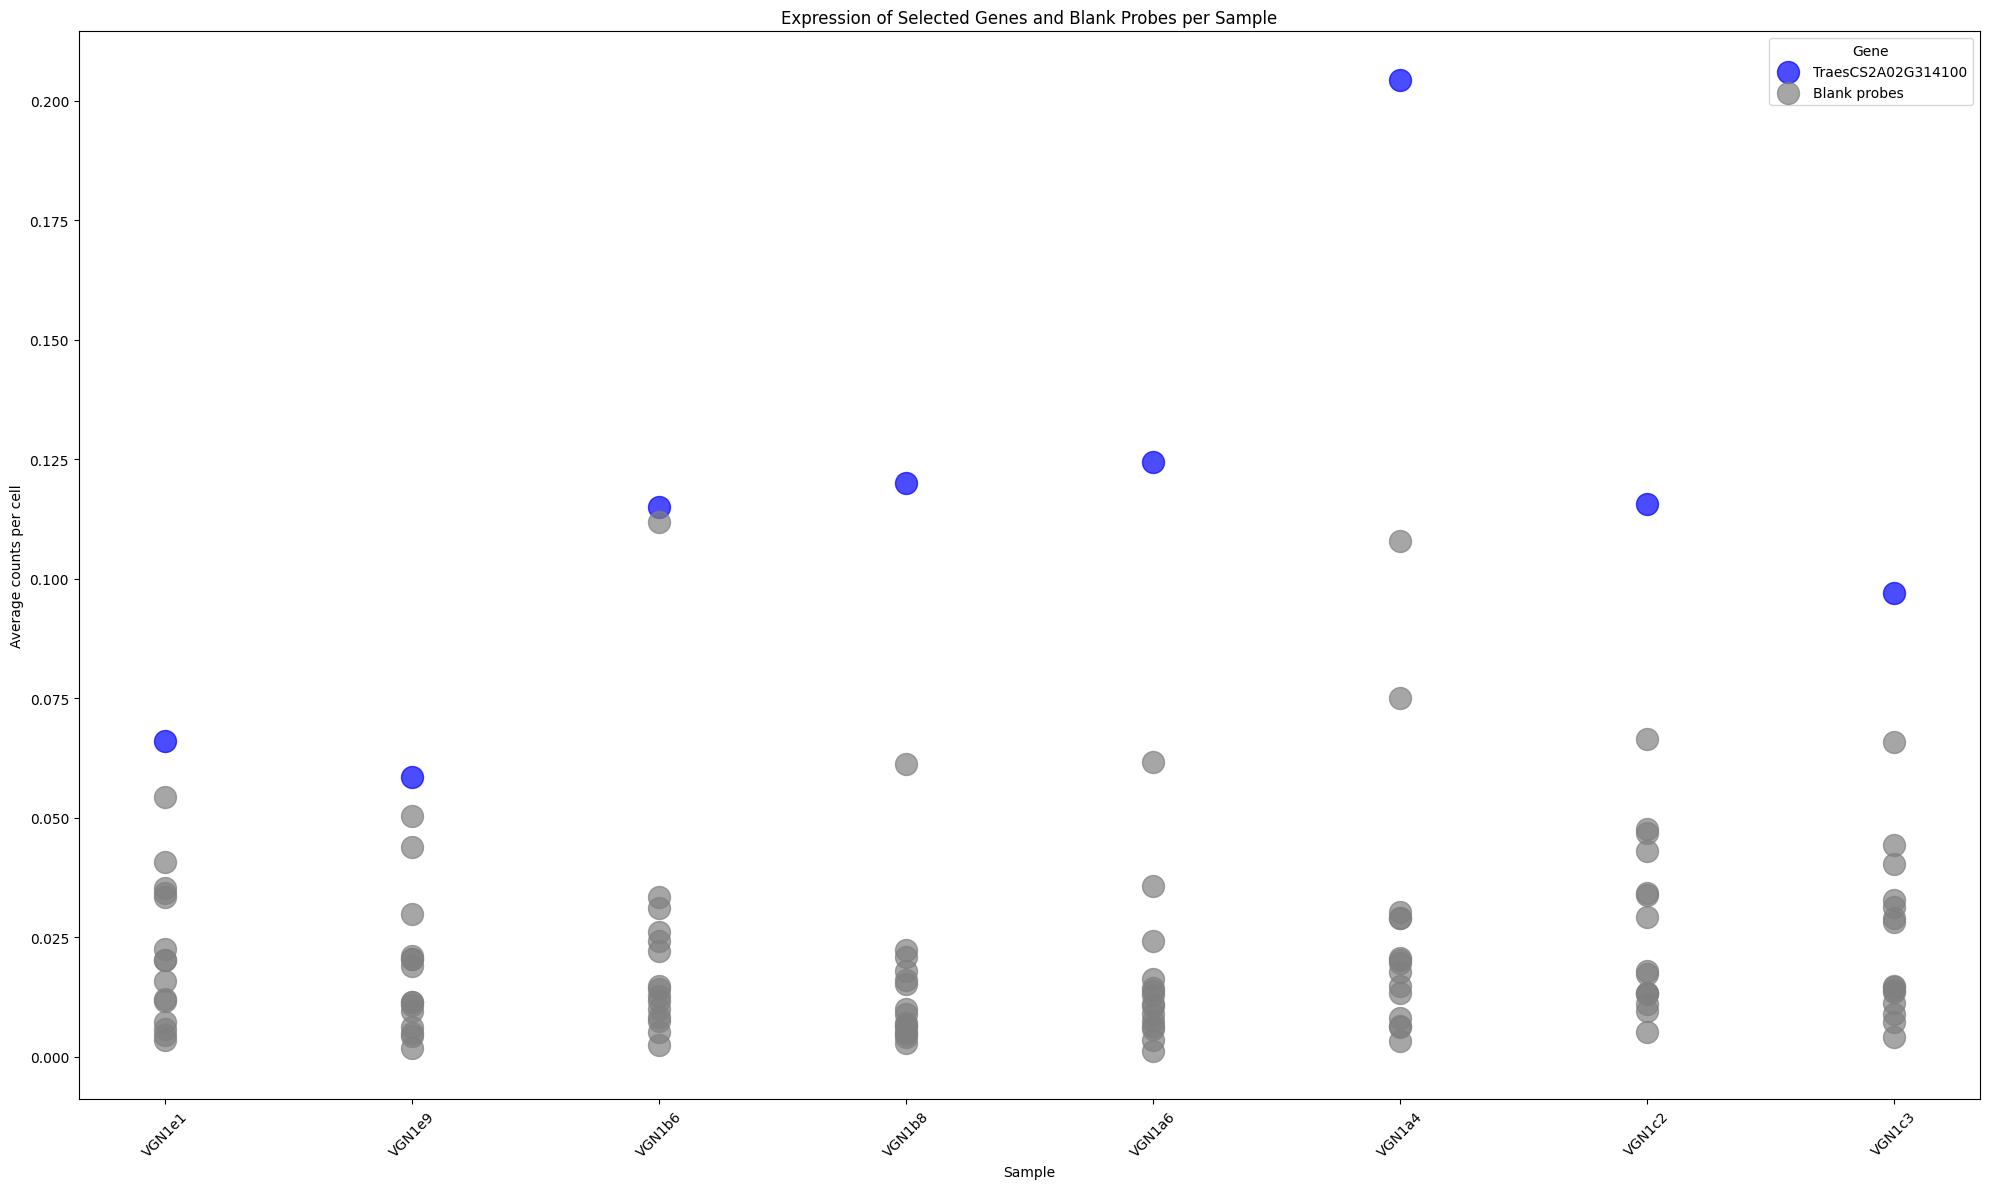

In [19]:
# Define columns to plot
columns_to_plot = [
    'TraesCS2A02G314100', 'Blank-0', 'Blank-1', 'Blank-2', 'Blank-3',
    'Blank-4', 'Blank-5', 'Blank-6', 'Blank-7', 'Blank-8', 'Blank-9', 'Blank-10', 
    'Blank-11', 'Blank-12', 'Blank-13', 'Blank-14'
]

# Specify the order of samples
sample_order = ['VGN1e1', 'VGN1e9', 'VGN1b6', 'VGN1b8', 'VGN1a6', 'VGN1a4', 'VGN1c2', 'VGN1c3']

# Reorder the DataFrame according to the specified sample order
plot_df = reshaped_df.loc[sample_order, columns_to_plot]

# Create the plot
plt.figure(figsize=(20, 12))

# Plot grey dots for Blank probes and add a legend entry for them
blank_plotted = False  # To ensure we only add one legend entry for 'Blank probes'
for col in columns_to_plot:
    if col.startswith("Blank"):
        color = 'grey'
        plt.scatter(plot_df.index, plot_df[col], color=color, s=250, alpha=0.7)
        if not blank_plotted:
            plt.scatter([], [], color='grey', label='Blank probes', s=250, alpha=0.7)  # Add grey dot to legend once
            blank_plotted = True
    elif col == 'TraesCS2A02G314100':
        plt.scatter(plot_df.index, plot_df[col], color='blue', label='TraesCS2A02G314100', s=250, alpha=0.7)

# Add legend with the specified labels
plt.legend(title='Gene', loc='upper right')

# Set labels and title
plt.xlabel('Sample')
plt.ylabel('Average counts per cell')
plt.title('Expression of Selected Genes and Blank Probes per Sample')

# Adjust x-axis tick labels
plt.xticks(rotation=45)
plt.tight_layout()
# Show the plot
plt.show()


## Visualsing the expression of the gene + homoeologs (TraesCS1B02G448400) in microdissection dataset

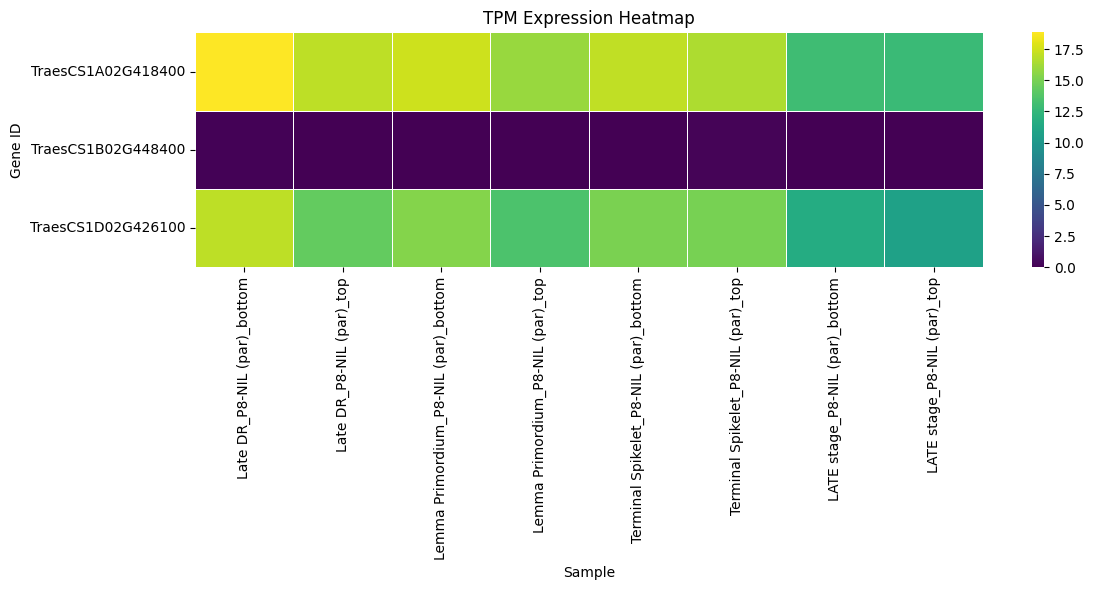

In [20]:
TPM_data = pd.read_csv('RNAseq/TPM_RNAseq_ImpulseDE2results.csv')

desired_order = [
    'gene_id',  
    'Late DR_P8-NIL (par)_bottom', 'Late DR_P8-NIL (par)_top', 
    'Lemma Primordium_P8-NIL (par)_bottom', 'Lemma Primordium_P8-NIL (par)_top', 
    'Terminal Spikelet_P8-NIL (par)_bottom', 'Terminal Spikelet_P8-NIL (par)_top', 
    'LATE stage_P8-NIL (par)_bottom', 'LATE stage_P8-NIL (par)_top'
]

# Reorder the DataFrame columns
TPM_data = TPM_data[desired_order]

TPM_data_filtered = TPM_data.copy()
TPM_data_filtered = TPM_data_filtered[TPM_data_filtered["gene_id"].isin(["TraesCS1B02G448400", "TraesCS1A02G418400", "TraesCS1D02G426100"])]


# Set 'gene_id' as index so it's used for the Y-axis
TPM_plot_data = TPM_data_filtered.set_index('gene_id')

# Create the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(TPM_plot_data, cmap='viridis', linewidths=0.5, linecolor='white')

# Label formatting
plt.xlabel('Sample')
plt.ylabel('Gene ID')
plt.title('TPM Expression Heatmap')
plt.tight_layout()
plt.savefig('qc/homoeolog_offtarget_activity/figures/TraesCS1B02G448400_HomoeologExpression_Heatmap.svg',  dpi=700, bbox_inches='tight', format='svg', transparent=True)
plt.show()
